# New ideas to test (optional)

**Part 1 / VAE training:**
- Simple model setup, that takes a single parameter to control the capacity of encoder and decoder
    - E.g. experiment with plain-vanilla VGG/AlexNet type net 
    - Play with dilated convolutions a bit for variety
- Loss, 2 parts
    - BCE / MSE loss part
    - KL based part
    - Optional ideas (but cool to test)
        - Try SSIM loss as a part, instead of BCE / MSE
        - Try automatic momentum-based dynamic loss weighting
- Experiment with some skip connections, just for the sake of it
- Play with some minor augmentations, just for the sake of it

**Part 2**
- Replace PCA with UMAP / T-SNE and see the difference

# Build a docker container (optional)

Essentially it just requires setting `pytorch=0.4.0`


Otherwise my standard Dockerfile seems to be a fit

If you will be using it, you can just replace my public key with yours (not necessary)

## Dockerfile (optional)

```
# add 7z tar and zip archivers
FROM nvidia/cuda:9.0-cudnn7-devel

# https://docs.docker.com/engine/examples/running_ssh_service/
RUN apt-get update && apt-get install -y openssh-server
RUN mkdir /var/run/sshd
RUN echo 'root:Ubuntu@41' | chpasswd
RUN sed -i 's/PermitRootLogin prohibit-password/PermitRootLogin yes/' /etc/ssh/sshd_config
RUN sed -i 's/#PasswordAuthentication yes/PasswordAuthentication no/' /etc/ssh/sshd_config
RUN mkdir ~/.ssh/
RUN touch ~/.ssh/authorized_keys
RUN echo 'ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQDPlILkHRoLnwMS3JlNO94FAYChrW+jGXMxFK5eRmCcBtTJRrV7zyv5mqIBhyJQFiQOqeycttVQP/HTJ9XCwVY0/WK5b45Z6PmfY9PJ5uiLahTCLi8ayoqhDsIWTlWYL03dG7Oz0WEwWQ6BDmSbfS12GEzWQTLqNh7nwsmTXE5503bRtmTre69625gT8c+mgvBOoQfMN1XePxJ14j8h1dVB1Y0geRLJb7yYd4Dl6tnEb3PyGizNVaiVYeBBTx6N/8lvSVA+FYR9mOg3yzYrJ0Aqyj33Oi+jvPqZP16EUhjCukKQWH3IzS1pRvYPCXzPYwvMGvBa00f9GPDccE0eiawH atmyre@Everett' >> ~/.ssh/authorized_keys 


# SSH login fix. Otherwise user is kicked off after login
RUN sed 's@session\s*required\s*pam_loginuid.so@session optional pam_loginuid.so@g' -i /etc/pam.d/sshd

ENV NOTVISIBLE "in users profile"
RUN echo "export VISIBLE=now" >> /etc/profile

ENV CONDA_DIR /opt/conda
ENV PATH $CONDA_DIR/bin:$PATH

# writing env variables to /etc/profile as mentioned here https://docs.docker.com/engine/examples/running_ssh_service/#run-a-test_sshd-container
RUN echo "export CONDA_DIR=/opt/conda" >> /etc/profile
RUN echo "export PATH=$CONDA_DIR/bin:$PATH" >> /etc/profile

RUN mkdir -p $CONDA_DIR && \
    echo export PATH=$CONDA_DIR/bin:'$PATH' > /etc/profile.d/conda.sh && \
    apt-get update && \
    apt-get install -y wget git libhdf5-dev g++ graphviz openmpi-bin nano && \
    wget --quiet https://repo.continuum.io/miniconda/Miniconda3-4.2.12-Linux-x86_64.sh && \
    echo "c59b3dd3cad550ac7596e0d599b91e75d88826db132e4146030ef471bb434e9a *Miniconda3-4.2.12-Linux-x86_64.sh" | sha256sum -c - && \
    /bin/bash /Miniconda3-4.2.12-Linux-x86_64.sh -f -b -p $CONDA_DIR && \
    ln /usr/lib/x86_64-linux-gnu/libcudnn.so /usr/local/cuda/lib64/libcudnn.so && \
    ln /usr/lib/x86_64-linux-gnu/libcudnn.so.7 /usr/local/cuda/lib64/libcudnn.so.7 && \
    ln /usr/include/cudnn.h /usr/local/cuda/include/cudnn.h  && \
    rm Miniconda3-4.2.12-Linux-x86_64.sh

ENV NB_USER keras
ENV NB_UID 1000

RUN echo "export NB_USER=keras" >> /etc/profile
RUN echo "export NB_UID=1000" >> /etc/profile

RUN echo "export LD_LIBRARY_PATH=/usr/local/cuda/lib64:/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH" >> /etc/profile
RUN echo "export CPATH=/usr/include:/usr/include/x86_64-linux-gnu:/usr/local/cuda/include:$CPATH" >> /etc/profile
RUN echo "export LIBRARY_PATH=/usr/local/cuda/lib64:/lib/x86_64-linux-gnu:$LIBRARY_PATH" >> /etc/profile
RUN echo "export CUDA_HOME=/usr/local/cuda" >> /etc/profile
RUN echo "export CPLUS_INCLUDE_PATH=$CPATH" >> /etc/profile
RUN echo "export KERAS_BACKEND=tensorflow" >> /etc/profile

RUN useradd -m -s /bin/bash -N -u $NB_UID $NB_USER && \
    mkdir -p $CONDA_DIR && \
    chown keras $CONDA_DIR -R  

USER keras

RUN  mkdir -p /home/keras/notebook

# Python
ARG python_version=3.6

RUN conda install -y python=${python_version} && \
    pip install --upgrade pip && \
    pip install tensorflow-gpu && \
    conda install Pillow scikit-learn notebook pandas matplotlib mkl nose pyyaml six h5py && \
    conda install theano pygpu bcolz && \
    pip install keras kaggle-cli lxml opencv-python requests scipy tqdm visdom && \
    conda install pytorch=0.4.0 cuda90 -c pytorch && \
    conda install torchvision -c pytorch && \
    pip install imgaug && \
    conda clean -yt

ENV LD_LIBRARY_PATH /usr/local/cuda/lib64:/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
ENV CPATH /usr/include:/usr/include/x86_64-linux-gnu:/usr/local/cuda/include:$CPATH
ENV LIBRARY_PATH /usr/local/cuda/lib64:/lib/x86_64-linux-gnu:$LIBRARY_PATH
ENV CUDA_HOME /usr/local/cuda
ENV CPLUS_INCLUDE_PATH $CPATH
ENV KERAS_BACKEND tensorflow

WORKDIR /home/keras/notebook

EXPOSE 8888 6006 22 8097

CMD jupyter notebook --port=8888 --ip=0.0.0.0 --no-browser
```

## Using my dockerfile (optional)

To build the docker image from the Dockerfile located in `dockerfile` please do:
```
cd dockerfile
docker build -t oulu_docker .
```

Also please make sure that [nvidia-docker2](https://github.com/nvidia/nvidia-docker/wiki/Installation-(version-2.0)) and proper nvidia drivers are installed.

To test the installation run
```
docker run --runtime=nvidia --rm nvidia/cuda nvidia-smi
```

Then launch the container as follows:
```
docker run --runtime=nvidia -e NVIDIA_VISIBLE_DEVICES=0 -it -v /your/folder/:/home/keras/notebook/your_folder -p 8888:8888 -p 6006:6006 --name oulu --shm-size 16G oulu_docker
```

Please note that w/o `--shm-size 16G` PyTorch dataloader classes will not work.
The above command will start a container with a Jupyter notebook server available via port `8888`. 
Port `6006` is for tensorboard, if necessary.

Then you can exec into the container like this. All the scripts were run as root, but they must also work under user `keras`
```
docker exec -it --user root REPLACE_WITH_CONTAINER_ID /bin/bash
```
or
```
docker exec -it --user keras REPLACE_WITH_CONTAINER_ID /bin/bash
```

To find out the container ID run
```
 docker container ls
```

## Best viewing the notebooks (optional)

Jupyter notebook is best viewed using these extensions (installed with the below command, then to be turned on in the **Jupyter GUI**)

```
pip install git+https://github.com/ipython-contrib/jupyter_contrib_nbextensions
# conda install html5lib==0.9999999
jupyter contrib nbextension install --system
```    
Sometims there is a `html5lib` conflict.
Excluded from the Dockerfile because of this conflict (sometimes occurs, sometimes not).
![](extensions.png)

# Prepare the CLI script

## Download data, write generator class

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_mnist(X, y, field_size=10):
    FIELD_SIZE = field_size

    ind = np.random.randint(0, X.shape[0], FIELD_SIZE*FIELD_SIZE)
    X_vis = X[ind, :].reshape(FIELD_SIZE, FIELD_SIZE, 28, 28) 
    y_vis = y[ind].reshape(FIELD_SIZE, FIELD_SIZE)

    plt.figure(figsize=(16, 16))

    for i in range(FIELD_SIZE):
        for j in range(FIELD_SIZE):
            plt.subplot(FIELD_SIZE, FIELD_SIZE, i*FIELD_SIZE+j+1)
            plt.imshow(X_vis[i, j, :], cmap=plt.cm.Greys)
            plt.gca().xaxis.set_ticks([])
            plt.gca().yaxis.set_ticks([])
            plt.title(y_vis[i, j])
    plt.tight_layout()
    plt.show()

class Visualizer:
    def __init__(self, size, title, xlabel, ylabel, max_epochs, min_val=None):
        self.fig = plt.figure(figsize=size)
        self.ax = plt.axes()
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_title(title)
        self.ax.set_xlim(1,max_epochs)
        self.ax.grid()
        self.min_val = min_val

    def update_plot(self, fold_losses, labels):
        if self.min_val is not None:
            self.ax.set_ylim(0, fold_losses.max()+fold_losses.max()*0.1)
        else:
            self.ax.set_ylim(fold_losses.max()*0.8, fold_losses.max()+fold_losses.max()*0.1)

        x = np.arange(1, fold_losses.shape[0]+1)

        if self.ax.lines:
            for i, line in enumerate(self.ax.lines):
                line.set_xdata(x)
                line.set_ydata(fold_losses[:, i])
        else:
            for i, label in enumerate(labels):
                self.ax.plot(x, fold_losses[:, i], label=label)

        self.fig.canvas.draw()
        self.ax.legend()

In [2]:
import os
import cv2
import time
import random 
import numpy as np
from PIL import Image
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold

cv2.setNumThreads(0)

class FMNISTDataset(data.Dataset):
    def __init__(self,
                 num_folds = 5,
                 fold = 0,
                 mode = 'train',
                 random_state = 42,
                 use_augs = False,
                ):
        
        self.X, self.y, self.X_test, self.y_test = self.get_fashion_mnist()
        self.fold = fold            
        self.num_folds = num_folds
        self.mode = mode
        self.random_state = random_state
        self.mean = self.X.reshape(60000, 28, 28).mean()/255
        self.std = self.X.reshape(60000, 28, 28).std()/255
        self.use_augs = use_augs
        
        skf = StratifiedKFold(n_splits = self.num_folds,
                              shuffle = True,
                              random_state = self.random_state)
        
        f1, f2, f3, f4, f5 = skf.split(self.X,self.y)
        
        folds = [f1, f2, f3, f4, f5]
        self.train_idx = folds[self.fold][0]
        self.val_idx = folds[self.fold][1] 
    def get_fashion_mnist(self):
        if not os.path.isfile('train-images-idx3-ubyte'):
            os.system('wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz')
            os.system('wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz')
            os.system('wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz')
            os.system('wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz')
            os.system('gunzip *.gz')

        with open('train-images-idx3-ubyte', 'rb') as f:
            X = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()
            X = X.reshape((60000, 28*28))

        with open('train-labels-idx1-ubyte', 'rb') as f:
            y = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

        with open('t10k-images-idx3-ubyte', 'rb') as f:
            X_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()
            X_test = X_test.reshape((10000, 28*28))

        with open('t10k-labels-idx1-ubyte', 'rb') as f:
            y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

        return X, y, X_test, y_test        
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_idx)
        elif self.mode == 'val':
            return len(self.val_idx)
    def __getitem__(self, idx):
        if self.mode == 'train':
            return_tuple = (self.preprocess_img(Image.fromarray(self.X[self.train_idx[idx]].reshape(28, 28))),
                            self.y[self.train_idx[idx]])
        elif self.mode == 'val':
            return_tuple = (self.preprocess_img(Image.fromarray(self.X[self.val_idx[idx]].reshape(28, 28))),
                            self.y[self.val_idx[idx]])            
        return return_tuple 
    def preprocess_img(self,
                       img):
        if self.use_augs == False:
            preprocessing = transforms.Compose([
                            transforms.CenterCrop(28),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[self.mean],
                                                 std=[self.std]),
                            ])            
        else:
            # do some naive augs
            preprocessing = transforms.Compose([
                            transforms.CenterCrop(28),
                            transforms.RandomHorizontalFlip(p=0.25),
                            transforms.RandomRotation(degrees=30),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[self.mean],
                                                 std=[self.std]),
                            ])  
        return preprocessing(img).numpy()            
    def reverse_normalize(tensor, mean, std):
        '''reverese normalize to convert tensor -> PIL Image'''
        tensor_copy = tensor.clone()
        for t, m, s in zip(tensor_copy, mean, std):
            t.div_(s).sub_(m)
        return tensor_copy
    def tensor2img(tensor, on_cuda=True):
        tensor = reverse_normalize(tensor, REVERSE_MEAN, REVERSE_STD)
        # clipping
        tensor[tensor > 1] = 1
        tensor[tensor < 0] = 0
        tensor = tensor.squeeze(0)
        if on_cuda:
            tensor = tensor.cpu()
        return transforms.ToPILImage()(tensor)    

In [3]:
import torch

train_dataset = FMNISTDataset(random_state = 42,
                              use_augs = True)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1000,        
    shuffle=True,
    num_workers=1,
    pin_memory=False,
    drop_last=False)

In [10]:
input.shape, target.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

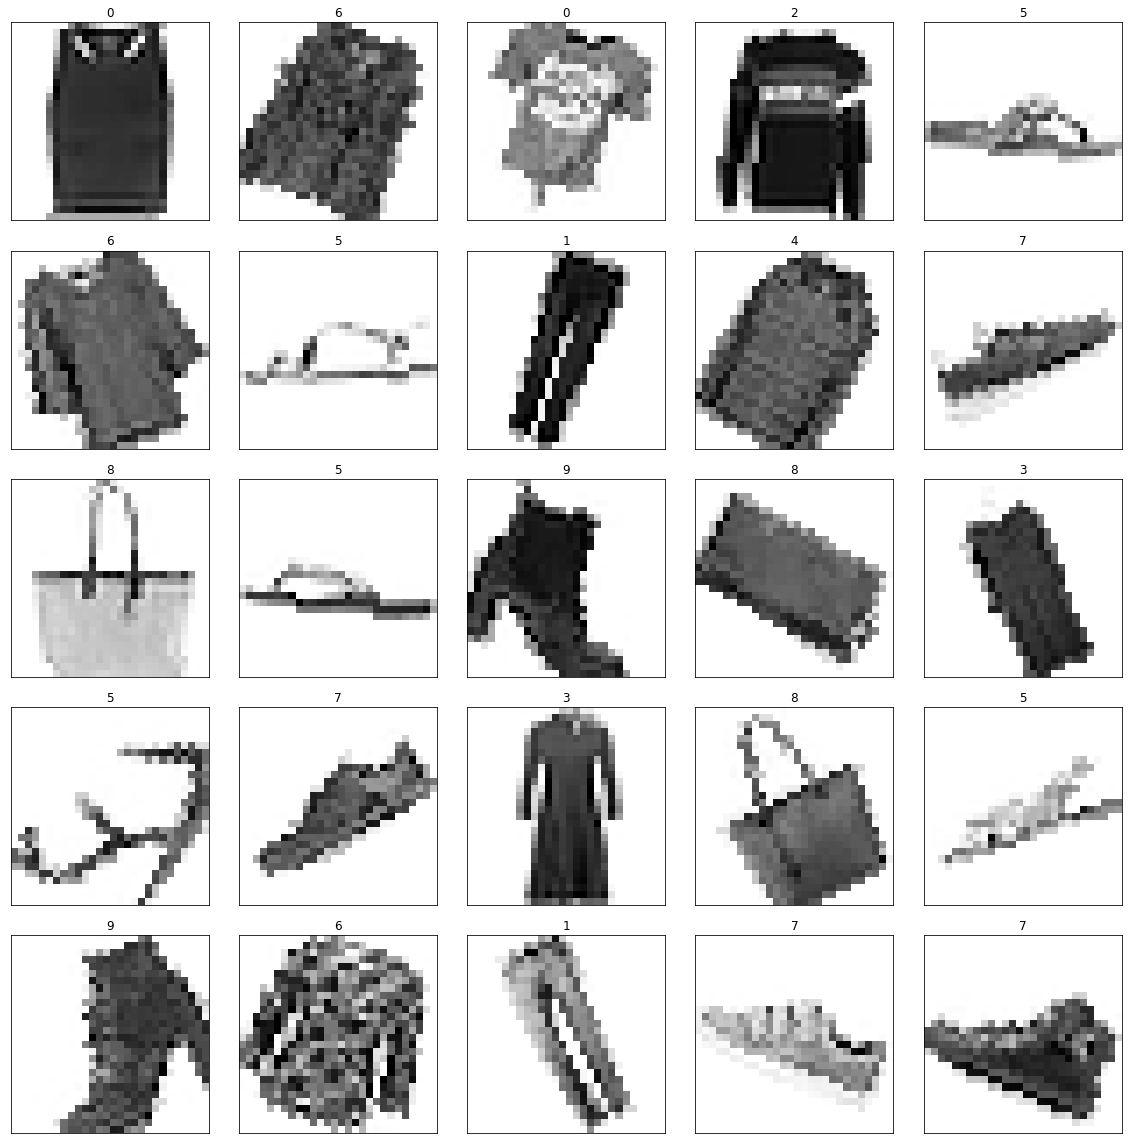

In [23]:
for i, (input, target) in enumerate(train_loader):
 
    img = input[:,0,:,:].numpy()
    img += -img.min()
    img *= (1/img.max())

    visualize_mnist(img,target.numpy(),field_size=5)
    

    break

## Write classes

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_mnist(X, y, field_size=10):
    FIELD_SIZE = field_size

    ind = np.random.randint(0, X.shape[0], FIELD_SIZE*FIELD_SIZE)
    X_vis = X[ind, :].reshape(FIELD_SIZE, FIELD_SIZE, 28, 28) 
    y_vis = y[ind].reshape(FIELD_SIZE, FIELD_SIZE)

    plt.figure(figsize=(16, 16))

    for i in range(FIELD_SIZE):
        for j in range(FIELD_SIZE):
            plt.subplot(FIELD_SIZE, FIELD_SIZE, i*FIELD_SIZE+j+1)
            plt.imshow(X_vis[i, j, :], cmap=plt.cm.Greys)
            plt.gca().xaxis.set_ticks([])
            plt.gca().yaxis.set_ticks([])
            plt.title(y_vis[i, j])
    plt.tight_layout()
    plt.show()

class Visualizer:
    def __init__(self, size, title, xlabel, ylabel, max_epochs, min_val=None):
        self.fig = plt.figure(figsize=size)
        self.ax = plt.axes()
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_title(title)
        self.ax.set_xlim(1,max_epochs)
        self.ax.grid()
        self.min_val = min_val

    def update_plot(self, fold_losses, labels):
        if self.min_val is not None:
            self.ax.set_ylim(0, fold_losses.max()+fold_losses.max()*0.1)
        else:
            self.ax.set_ylim(fold_losses.max()*0.8, fold_losses.max()+fold_losses.max()*0.1)

        x = np.arange(1, fold_losses.shape[0]+1)

        if self.ax.lines:
            for i, line in enumerate(self.ax.lines):
                line.set_xdata(x)
                line.set_ydata(fold_losses[:, i])
        else:
            for i, label in enumerate(labels):
                self.ax.plot(x, fold_losses[:, i], label=label)

        self.fig.canvas.draw()
        self.ax.legend()

In [38]:
import torch
from FMNISTDataset import FMNISTDataset

train_dataset = FMNISTDataset(random_state = 42,
                              use_augs = True)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1000,        
    shuffle=True,
    num_workers=1,
    pin_memory=False,
    drop_last=False)

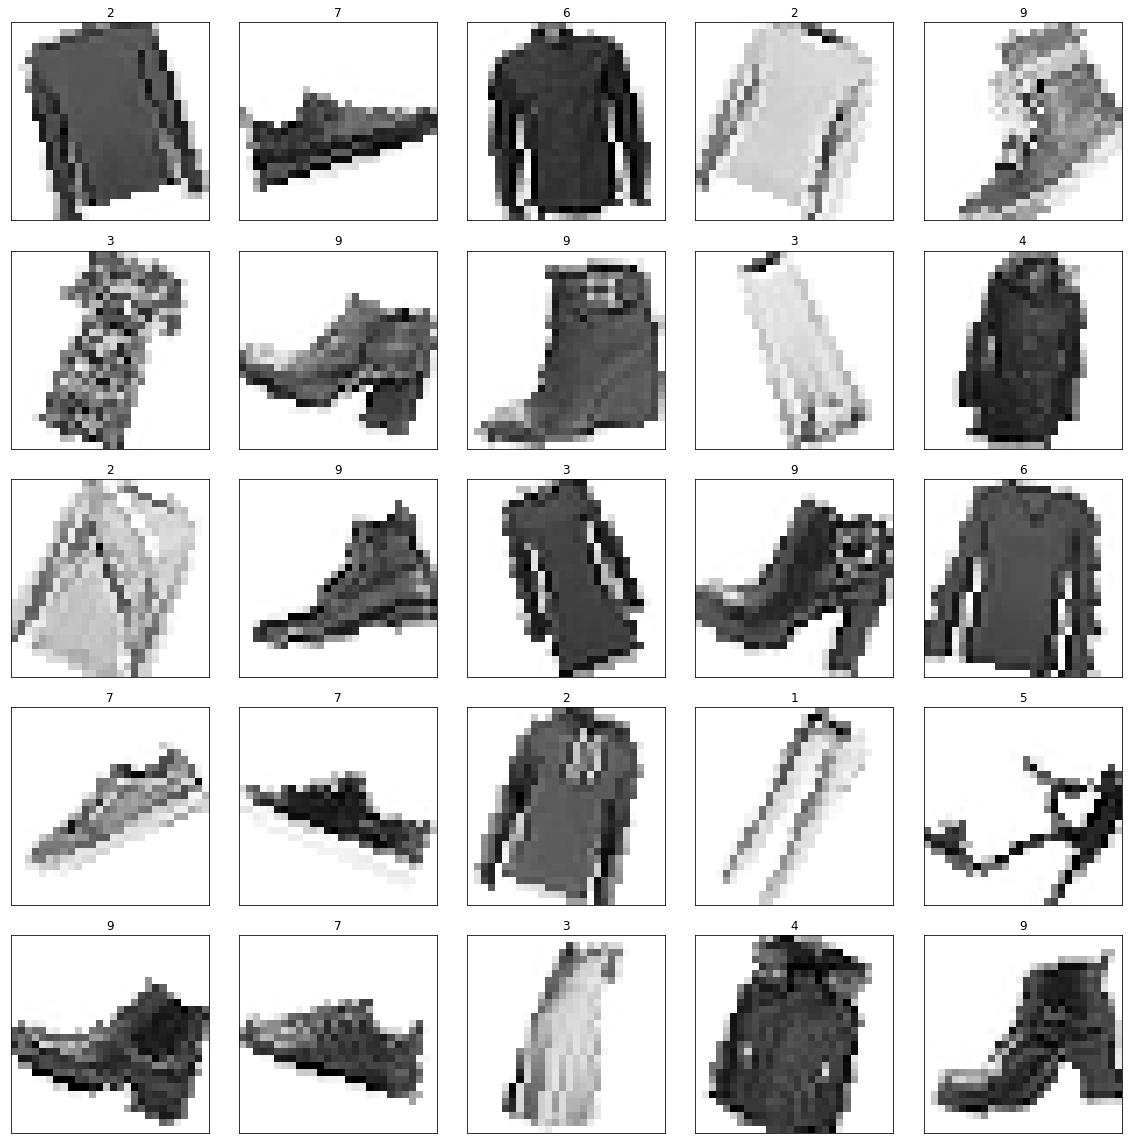

In [39]:
for i, (input, target) in enumerate(train_loader):
 
    img = input[:,0,:,:].numpy()
    img += -img.min()
    img *= (1/img.max())

    visualize_mnist(img,target.numpy(),field_size=5)
    

    break

In [59]:
import torch
from torch import nn
from torch.nn import functional as F

class EncoderBlock(nn.Module):
    def __init__(self,
                 in_,
                 out,
                 padding=1,
                 dilation=1,
                 stride=1,
                 activation=nn.ReLU(inplace=True),
                 kernel_size=3):
        super().__init__()
        
        self.conv = nn.Conv2d(in_,
                     out,
                     kernel_size,
                     padding=padding,
                     dilation=dilation,
                     stride=stride)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        print(x.shape)
        return x
     
class DecoderBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=4,
                 padding=1,
                 dilation=1,
                 stride=2,
                 activation=nn.ReLU(inplace=True)
                ):

        super(DecoderBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               dilation=dilation),
            activation
        )
    def forward(self, x):
        x = self.block(x)
        print(x.shape)
        return x 
    
class VAEView(nn.Module):
    def __init__(self,
                 filters           =[1, 6, 12, 24],
                 dilations         =[1, 1, 1],
                 paddings          =[1, 1, 1],
                 strides           =[2, 2, 2],
                 decoder_kernels   =[4, 4, 3],
                 decoder_paddings  =[1, 1, 1], 
                 decoder_strides   =[2, 2, 2],
                 latent_space_size = 10): 
        super().__init__()

        self.filters = filters
        modules = []
        decoder_modules = []
        
        for i in range(0,len(filters)-1):
            modules = self.add_conv_block(modules,
                                          EncoderBlock,
                                          filters[i],
                                          filters[i+1],
                                          dilations[i],
                                          paddings[i],
                                          strides[i])
            
            decoder_modules = self.add_conv_block(decoder_modules,
                                          DecoderBlock,
                                          filters[i+1],
                                          filters[i],
                                          dilations[i],
                                          decoder_paddings[i],
                                          decoder_strides[i],
                                          decoder_kernels[i])
            
        # make sure the weights are shared
        self.encoder = nn.Sequential(*modules) 
        
        self.mu_encoder = nn.Conv2d(4*4*filters[-1],latent_space_size, kernel_size=3, stride=1, padding=1)
        self.logvar_encoder = nn.Conv2d(4*4*filters[-1],latent_space_size, kernel_size=3,  stride=1, padding=1)        

        self.decoder_transition = EncoderBlock(latent_space_size,4*4*filters[-1])
        self.decoder = nn.Sequential(*reversed(decoder_modules))
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000        
            
    def encode(self,x):
        x = self.encoder(x)
        x = x.view(x.shape[0],-1,1,1)
        
        print(x.shape)

        mu = self.mu_encoder(x)
        logvar = self.logvar_encoder(x)
        
        return mu,logvar

    def decode(self, z):
        z = self.decoder_transition(z)
        z = z.view(-1,self.filters[-1],4,4)
        z = self.decoder(z)
        return F.sigmoid(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        # print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def add_conv_block(self,
                       modules,
                       block,
                       filters_in,
                       filters_out,
                       dilation,
                       padding,
                       stride,
                       kernel_size=3
                       ):
       
        modules.append(block(filters_in,
                             filters_out,
                             padding=padding,
                             dilation=dilation,
                             stride=stride,
                             kernel_size=kernel_size))
        
        return modules
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
class VAE1N(nn.Module):
    def __init__(self,
                 filters           =[1, 6, 12, 24],
                 dilations         =[1, 1, 1],
                 paddings          =[1, 1, 1],
                 strides           =[2, 2, 2],
                 decoder_kernels   =[4, 4, 3],
                 decoder_paddings  =[1, 1, 1], 
                 decoder_strides   =[2, 2, 2],
                 latent_space_size = 10): 
        super().__init__()

        self.filters = filters
        modules = []
        decoder_modules = []
        
        for i in range(0,len(filters)-1):
            modules = self.add_conv_block(modules,
                                          EncoderBlock,
                                          filters[i],
                                          filters[i+1],
                                          dilations[i],
                                          paddings[i],
                                          strides[i])
            
            decoder_modules = self.add_conv_block(decoder_modules,
                                          DecoderBlock,
                                          filters[i+1],
                                          filters[i],
                                          dilations[i],
                                          decoder_paddings[i],
                                          decoder_strides[i],
                                          decoder_kernels[i])
            
        # make sure the weights are shared
        self.encoder = nn.Sequential(*modules) 
        
        self.mu_encoder = nn.Conv1d(1,latent_space_size, kernel_size=(4*4*filters[-1]), stride=1, padding=0)
        self.logvar_encoder = nn.Conv1d(1,latent_space_size, kernel_size=(4*4*filters[-1]),  stride=1, padding=0)     

        self.decoder_transition = nn.Sequential(
            nn.ConvTranspose1d(latent_space_size,1, kernel_size=(4*4*filters[-1]),  stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(*reversed(decoder_modules))
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000        
            
    def encode(self,x):
        x = self.encoder(x)
        x = x.view(x.shape[0],1,-1)
        
        print(x.shape)

        mu = self.mu_encoder(x)
        logvar = self.logvar_encoder(x)
        
        print(mu.shape)
        print(logvar.shape)
        
        return mu,logvar

    def decode(self, z):
        z = self.decoder_transition(z)
        z = z.view(-1,self.filters[-1],4,4)
        z = self.decoder(z)
        return F.sigmoid(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        # print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def add_conv_block(self,
                       modules,
                       block,
                       filters_in,
                       filters_out,
                       dilation,
                       padding,
                       stride,
                       kernel_size=3
                       ):
       
        modules.append(block(filters_in,
                             filters_out,
                             padding=padding,
                             dilation=dilation,
                             stride=stride,
                             kernel_size=kernel_size))
        
        return modules
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu        
        
class VAESimplifiedFC(nn.Module):
    def __init__(self):
        super().__init__()
        
        # make sure the weights are shared
        self.encoder = nn.Sequential(
            nn.Conv2d(1,4,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4,8,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8,16,3,stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,32,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,3,stride=2),
            nn.ReLU(inplace=True),            
        ) 
        self.mu_encoder = nn.Sequential(
            nn.Linear(64*4*4, 10)          
        ) 
        self.logvar_encoder = nn.Sequential(
            nn.Linear(64*4*4, 10)
        )       
        self.linear_decoder = nn.Sequential(
            nn.Linear(10, 64*4*4),
            nn.ReLU(inplace=True),
        )       
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32,16,4,stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,4,stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,4,4,stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(4,1,3,stride=1, padding=(1, 1)),
            nn.ReLU(inplace=True),              
        ) 
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000        
            
    def encode(self,x):
        x = self.encoder(x)
        x = x.view(-1,64*4*4)
        mu = self.mu_encoder(x)
        logvar = self.logvar_encoder(x)
        return mu,logvar

    def decode(self, z):
        z = self.linear_decoder(z)
        z = z.view(-1,64,4,4)
        z = self.decoder(z)
        return F.sigmoid(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        # print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu        

class VAESimplified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # make sure the weights are shared
        self.encoder = nn.Sequential(
            nn.Conv2d(1,4,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(4,8,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8,16,3,stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,32,3,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,3,stride=2),
            nn.ReLU(inplace=True),            
        ) 
        self.mu_encoder = nn.Sequential(
            nn.Conv2d(64,10,3,stride=2),
            nn.ReLU(inplace=True),            
        ) 
        self.logvar_encoder = nn.Sequential(
            nn.Conv2d(64,10,3,stride=2),
            nn.ReLU(inplace=True),          
        )       

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10,64,4,stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,32,4,stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32,16,4,stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,4,stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,4,4,stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(4,1,3,stride=1, padding=(1, 1)),
            nn.ReLU(inplace=True),              
        ) 
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000        
            
    def encode(self,x):
        x = self.encoder(x)
        mu = self.mu_encoder(x)
        logvar = self.logvar_encoder(x)
        return mu,logvar

    def decode(self, z):
        z = self.decoder(z)
        return F.sigmoid(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        # print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu        
        
class VAEBaselineConv(nn.Module):
    def __init__(self,
                 latent_space_size=10):
        super(VAEBaselineConv, self).__init__()
        self.fc1 = nn.Conv2d(1,32, kernel_size=(28,28), stride=1, padding=0)
        self.fc21 = nn.Conv2d(32,latent_space_size, kernel_size=(1,1), stride=1, padding=0)
        self.fc22 = nn.Conv2d(32,latent_space_size, kernel_size=(1,1), stride=1, padding=0)
        
        self.fc3 = nn.ConvTranspose2d(latent_space_size,118, kernel_size=(1,1),  stride=1, padding=0)
        self.fc4 = nn.ConvTranspose2d(118,1, kernel_size=(28,28),  stride=1, padding=0)
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000    
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)         

In [60]:
model = VAEBaselineConv(latent_space_size=10)

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

Total model parameters 119591
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10, 1, 1]) torch.Size([1000, 10, 1, 1])
torch.Size([1000, 1, 28, 28])


In [143]:
model = VAESimplifiedFC()

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

Total model parameters 100021
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [137]:
multiplier = 4
filter_list = [1,
               int(multiplier*4),
               int(multiplier*8),
               int(multiplier*16),
              ]
print(filter_list)

model = VAE1N(filters       =filter_list,
            dilations         =[1, 1, 1],
            paddings          =[1, 1, 1],
            strides           =[2, 2, 2],
            decoder_kernels   =[4, 4, 3],
            decoder_paddings  =[1, 1, 1], 
            decoder_strides   =[2, 2, 2],
            latent_space_size = 10 )

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

[1, 16, 32, 64]
Total model parameters 80966
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 16, 14, 14])
torch.Size([1000, 32, 7, 7])
torch.Size([1000, 64, 4, 4])
torch.Size([1000, 1, 1024])
torch.Size([1000, 10, 1])
torch.Size([1000, 10, 1])
torch.Size([1000, 32, 7, 7])
torch.Size([1000, 16, 14, 14])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [11]:
from VAE import VAE

multiplier = 1
filter_list = [1,
               int(multiplier*8), int(multiplier*8),
               int(multiplier*16), int(multiplier*16),
               int(multiplier*32), int(multiplier*32),
               10]
print(filter_list)

model = VAE(filters          =filter_list,
            dilations        =[1, 1, 1, 1, 1, 1, 1],
            paddings         =[1, 1, 1, 1, 1, 1, 1],
            strides          =[1, 2, 1, 2, 1, 2, 1],
            decoder_kernels  =[3, 4, 4, 4, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2, 1, 1, 1],
            split_filter = 1)

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

[1, 8, 8, 16, 16, 32, 32, 10]
Total model parameters 60869
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 8, 28, 28])
torch.Size([1000, 8, 14, 14])
torch.Size([1000, 16, 14, 14])
torch.Size([1000, 16, 7, 7])
torch.Size([1000, 32, 7, 7])
torch.Size([1000, 32, 4, 4])
torch.Size([1000, 10, 4, 4])
torch.Size([1000, 10, 4, 4])
torch.Size([1000, 32, 7, 7])
torch.Size([1000, 32, 10, 10])
torch.Size([1000, 16, 13, 13])
torch.Size([1000, 16, 28, 28])
torch.Size([1000, 8, 31, 31])
torch.Size([1000, 8, 34, 34])
torch.Size([1000, 1, 34, 34])
torch.Size([1000, 1, 34, 34])


In [4]:
from VAE import VAE

multiplier = 1
filter_list = [1, int(multiplier*4), int(multiplier*8), int(multiplier*16), int(multiplier*32), int(multiplier*64), 10]
print(filter_list)

model = VAE(filters          =filter_list,
            dilations        =[1, 1, 1, 1, 1, 1],
            paddings         =[0, 0, 0, 0, 0, 0],
            strides          =[1, 1, 2, 1, 2, 2],
            decoder_kernels  =[3, 4, 4, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2, 2, 1],
            split_filter = 1)

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

[1, 4, 8, 16, 32, 64, 10]
Total model parameters 90101
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 4, 26, 26])
torch.Size([1000, 8, 24, 24])
torch.Size([1000, 16, 11, 11])
torch.Size([1000, 32, 9, 9])
torch.Size([1000, 64, 4, 4])
torch.Size([1000, 10, 1, 1])
torch.Size([1000, 10, 1, 1])
torch.Size([1000, 64, 4, 4])
torch.Size([1000, 32, 10, 10])
torch.Size([1000, 16, 22, 22])
torch.Size([1000, 8, 25, 25])
torch.Size([1000, 4, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [15]:
from VAE import VAE

multiplier = 1
filter_list = [1, int(multiplier*4), int(multiplier*8), int(multiplier*16), int(multiplier*32), int(multiplier*64), 10]
print(filter_list)

model = VAE(filters          =filter_list,
            dilations        =[1, 1, 1, 1, 1, 1],
            paddings         =[0, 0, 0, 0, 0, 0],
            strides          =[1, 1, 2, 1, 2, 2],
            decoder_kernels  =[3, 4, 4, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2, 2, 1],
            split_filter = 1)

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

[1, 4, 8, 16, 32, 64, 10]
Total model parameters 90101
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 4, 26, 26])
torch.Size([1000, 8, 24, 24])
torch.Size([1000, 16, 11, 11])
torch.Size([1000, 32, 9, 9])
torch.Size([1000, 64, 4, 4])
torch.Size([1000, 10, 1, 1])
torch.Size([1000, 10, 1, 1])
torch.Size([1000, 64, 4, 4])
torch.Size([1000, 32, 10, 10])
torch.Size([1000, 16, 22, 22])
torch.Size([1000, 8, 25, 25])
torch.Size([1000, 4, 28, 28])
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])


In [10]:
mu.shape,logvar.shape

(torch.Size([1000, 10, 1, 1]), torch.Size([1000, 10, 1, 1]))

In [191]:
multiplier = 2
filter_list = [1, multiplier*2, multiplier*16, multiplier*8, 10]

model = VAE(filters          =filter_list,
            dilations        =[1, 1, 1, 1],
            paddings         =[0, 0, 0, 0],
            strides          =[1, 1, 2, 1],
            decoder_kernels  =[3, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2])

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

Total model parameters 20187
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10, 9, 9]) torch.Size([1000, 10, 9, 9])
torch.Size([1000, 1, 26, 26])


In [13]:
model

VAE(
  (encoder): Sequential(
    (0): EncoderBlock(
      (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU(inplace)
    )
    (1): EncoderBlock(
      (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU(inplace)
    )
    (2): EncoderBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (activation): ReLU(inplace)
    )
  )
  (mu_encoder): Sequential(
    (0): EncoderBlock(
      (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU(inplace)
    )
    (1): EncoderBlock(
      (conv): Conv2d(16, 12, kernel_size=(3, 3), stride=(2, 2))
      (activation): ReLU(inplace)
    )
    (2): EncoderBlock(
      (conv): Conv2d(12, 10, kernel_size=(3, 3), stride=(2, 2))
      (activation): ReLU(inplace)
    )
  )
  (logvar_encoder): Sequential(
    (0): EncoderBlock(
      (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (activation): ReLU(inplace)
    )
    (1): Encoder

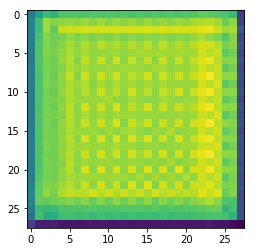

In [8]:
plt.imshow(out[0,0].detach().numpy())

In [8]:
multiplier = 2
filter_list = [1, int(multiplier*2), int(multiplier*8), int(multiplier*16), int(multiplier*8), int(multiplier*6), 10]
print(filter_list)

model = VAE(filters          =filter_list,
            dilations        =[1, 1, 1, 1, 1, 1],
            paddings         =[0, 0, 0, 0, 0, 0],
            strides          =[1, 1, 2, 1, 2, 2],
            decoder_kernels  =[3, 4, 4, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2, 2, 1])

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

[1, 4, 16, 32, 16, 12, 10]
Total model parameters 35243
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10, 1, 1]) torch.Size([1000, 10, 1, 1])
torch.Size([1000, 1, 28, 28])


In [188]:
model = VAE(filters          =[1, 8, 16, 32, 16, 16, 10],
            dilations        =[1, 1, 1, 1, 1, 1],
            paddings         =[0, 0, 0, 0, 0, 0],
            strides          =[1, 1, 2, 1, 2, 2],
            decoder_kernels  =[3, 4, 4, 4, 4, 4],
            decoder_paddings =[1, 0, 0, 0, 0, 0], 
            decoder_strides  =[1, 1, 1, 2, 2, 1])

# print(model)
print(input.shape)
out, mu, logvar = model(input)
print(out.shape)

Total model parameters 39531
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 10, 1, 1]) torch.Size([1000, 10, 1, 1])
torch.Size([1000, 1, 28, 28])


In [14]:
count_parameters(model)

1562

In [17]:
model

VAE(
  (conv_blocks): Sequential(
    (0): ConvRelu(
      (conv): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU(inplace)
    )
    (1): ConvRelu(
      (conv): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU(inplace)
    )
    (2): ConvRelu(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU(inplace)
    )
  )
)

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

class EncoderBlock(nn.Module):
    def __init__(self,
                 in_,
                 out,
                 padding=1,
                 dilation=1,
                 stride=1,
                 activation=nn.ReLU(inplace=True),
                 kernel_size=3):
        super().__init__()
        
        self.conv = nn.Conv2d(in_,
                     out,
                     kernel_size,
                     padding=padding,
                     dilation=dilation,
                     stride=stride)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x
     
class DecoderBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=4,
                 padding=1,
                 dilation=0,
                 stride=2,
                 activation=nn.ReLU(inplace=True)
                ):

        super(DecoderBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               dilation=dilation),
            activation
        )
    def forward(self, x):
        return self.block(x) 
    
class VAE(nn.Module):
    def __init__(self,
                 use_skip_connections=False,
                 filters          =[1, 16, 32, 64, 32, 16, 10],
                 dilations        =[1, 1, 1, 1, 1, 1],
                 paddings         =[0, 0, 0, 0, 0, 0],
                 strides          =[1, 1, 2, 1, 2, 2],
                 decoder_kernels  =[3, 4, 4, 4, 4, 4],
                 decoder_paddings =[1, 0, 0, 0, 0, 0],
                 decoder_strides  =[1, 1, 1, 2, 2, 1]):
        super().__init__()
        
        modules = []
        decoder_modules = []
        
        for i in range(0,len(filters)-1):
            modules = self.add_conv_block(modules,
                                          EncoderBlock,
                                          filters[i],
                                          filters[i+1],
                                          dilations[i],
                                          paddings[i],
                                          strides[i])
            
            decoder_modules = self.add_conv_block(decoder_modules,
                                          DecoderBlock,
                                          filters[i+1],
                                          filters[i],
                                          dilations[i],
                                          decoder_paddings[i],
                                          decoder_strides[i],
                                          decoder_kernels[i])
        
        # make sure the weights are shared
        self.encoder = nn.Sequential(*modules[:-3]) 
        self.mu_encoder = nn.Sequential(*modules[-3:])
        self.logvar_encoder = nn.Sequential(*modules[-3:])        

        self.decoder = nn.Sequential(*reversed(decoder_modules))
        
        print('Total model parameters {}'.format(self.count_parameters()))
        assert self.count_parameters() < 120000        
            
    def encode(self,x):
        x = self.encoder(x)
        mu = self.mu_encoder(x)
        logvar = self.logvar_encoder(x)
        return mu,logvar

    def decode(self, z):
        z = self.decoder(z)
        # usually having sigmoid inside of the PyTorch model is bad taste
        # but in this case it is more reasonable
        return F.sigmoid(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        print(mu.shape,logvar.shape)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def add_conv_block(self,
                       modules,
                       block,
                       filters_in,
                       filters_out,
                       dilation,
                       padding,
                       stride,
                       kernel_size=3
                       ):
       
        modules.append(block(filters_in,
                             filters_out,
                             padding=padding,
                             dilation=dilation,
                             stride=stride,
                             kernel_size=kernel_size))
        
        return modules
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

In [270]:
criterion = VAELoss(use_running_mean=False,
                    image_loss_type='bce',
                    image_loss_weight=1,
                    kl_loss_weight=1,
                    ssim_window_size=5)

loss,image_loss,kl_loss = criterion(out,
                                    input,
                                    mu,
                                    logvar)

print(loss)
print(image_loss)
print(kl_loss)

tensor(0.7356)
tensor(0.7320)
tensor(1.00000e-03 *
       3.6563)


tensor(0.1945)
tensor(0.1908)
tensor(1.00000e-03 *
       3.6563)


In [254]:
out.shape,input.shape,mu.shape,logvar.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 10, 1, 1]),
 torch.Size([1000, 10, 1, 1]))

torch.Size([]) torch.Size([])
tensor(1.00000e+05 *
       1.4962)
tensor(36.5628)


In [250]:
loss

tensor(1.00000e+05 *
       5.7392)

In [264]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_ssim import SSIM as SSIMLoss

class VAELoss(nn.Module):
    def __init__(self,
                 use_running_mean=False,
                 image_loss_type='bce',# 'bce','mse' or ssim
                 image_loss_weight=1,
                 kl_loss_weight=1,
                 ssim_window_size=5,
                 eps=1e-10,
                 gamma=0.9
                 ):
        super().__init__()

        if image_loss_type=='bce':
            self.image_loss = nn.BCELoss(size_average=True)
        elif image_loss_type=='mse':
            self.image_loss = nn.MSELoss(size_average=True)
        elif image_loss_type=='ssim':
            self.image_loss = SSIMLoss(window_size = ssim_window_size, size_average = True)
            
        self.image_loss_type = image_loss_type
        self.use_running_mean = use_running_mean            
        self.image_loss_weight = image_loss_weight
        self.kl_loss_weight = kl_loss_weight
        self.eps = eps
        self.gamma = gamma 
        
        if self.use_running_mean == True:
            self.register_buffer('running_image_loss', torch.zeros(1))
            self.register_buffer('running_kl_loss', torch.zeros(1))
            self.reset_parameters()

    def reset_parameters(self):
        self.running_image_loss.zero_()        
        self.running_kl_loss.zero_()            

    def forward(self, 
                outputs,
                targets,
                mu,
                logvar):
        
        # inputs and targets are assumed to be BxCxWxH
        assert len(outputs.shape) == len(targets.shape)
        # assert that B, W and H are the same
        assert outputs.size(0) == targets.size(0)
        assert outputs.size(2) == targets.size(2)
        assert outputs.size(3) == targets.size(3)
        
        assert mu.size(1) == 10
        assert logvar.size(1) == 10
        assert mu.size(2) == 1
        assert logvar.size(2) == 1
        assert mu.size(3) == 1
        assert logvar.size(3) == 1    
        
        image_loss = self.image_loss(outputs, targets)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        if self.use_running_mean == False:
            imw = self.image_loss_weight
            kmw = self.kl_loss_weight
        else:
            self.running_image_loss = self.running_image_loss * self.gamma + image_loss.data * (1 - self.gamma)        
            self.running_kl_loss = self.running_kl_loss * self.gamma + kl_loss.data * (1 - self.gamma)

            im = float(self.running_image_loss)
            km = float(self.running_kl_loss)

            imw = 1 - im / (im + km)
            kmw = 1 - km / (im + km)
                
        loss = image_loss * imw + kl_loss * kmw
        
        return loss,image_loss,kl_loss

In [ ]:
torch.mean

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Baseline code

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image



parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)


device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

    """
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
    """

# Training the VAE

**The best model can be trained as follows**

```
python3 train.py \
	--epochs 30 --batch-size 512 --seed 42 \
	--model_type fc_conv --dataset_type fmnist --latent_space_size 10 \
	--do_augs False \
	--lr 1e-3 --m1 40 --m2 50 \
	--optimizer adam \
	--do_running_mean False --img_loss_weight 1.0 --kl_loss_weight 1.0 \
	--image_loss_type bce --ssim_window_size 5 \
	--print-freq 10 \
	--lognumber fmnist_fc_conv_l10_rebalance_no_norm \
	--tensorboard True --tensorboard_images True \
```

If you launch this code, the copy of `FMNIST` dataset will be dowloaded automatically.

Suggested alternative values for the flags for playing with them:
- `dataset_type` - can be set to `mnist` and `fmnist`. In each case will download the necessary dataset
- `latent_space_size` - will affect the latent space in combination with `model_type` `fc_conv` or `fc`. Other model types do not work properly
- `m1` and `m2` control lr decay, but it did not really help here
- `image_loss_type` can be set to `bce`, `mse` or `ssim`. In practice `bce` works best. `mse` is worse. I suppose that proper scaling is required to make it work with `ssim` (it does not train now)
- `tensorboard`  and `tensorboard_images` can also be set to `False`. But they just write logs, so you may just not bother

These flags are optional `--tensorboard True --tensorboard_images True`, in order to use them, you have to 
- install tensorboard (installs with tensorflow)
- launch tensorboard with the following command `tensorboard --logdir='path/to/tb_logs' --port=6006`

You can also resume from the best checkpoint using these flags:
```
python3 train.py \
	--resume weights/fmnist_fc_conv_l10_rebalance_no_norm_best.pth.tar \
	--epochs 60 --batch-size 512 --seed 42 \
	--model_type fc_conv --dataset_type fmnist --latent_space_size 10 \
	--do_augs False \
	--lr 1e-3 --m1 50 --m2 100 \
	--optimizer adam \
	--do_running_mean False --img_loss_weight 1.0 --kl_loss_weight 1.0 \
	--image_loss_type bce --ssim_window_size 5 \
	--print-freq 10 \
	--lognumber fmnist_resume \
	--tensorboard True --tensorboard_images True \
```

The best reconstructions are supposed to look like this (top row - original images, bottow row - reconstructions):
![](reconstructions.png)

**Brief ablation analysis of the results**

**✓ What worked**
1. Using BCE loss + KLD loss
2. Converting a plain FC model into a conv model in the most straight-forward fashion possible, i.e. replacing this
```
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_space_size)
        self.fc22 = nn.Linear(400, latent_space_size)
        self.fc3 = nn.Linear(latent_space_size, 400)
        self.fc4 = nn.Linear(400, 784)
```        
with this
```
        self.fc1 = nn.Conv2d(1,32, kernel_size=(28,28), stride=1, padding=0)
        self.fc21 = nn.Conv2d(32,latent_space_size, kernel_size=(1,1), stride=1, padding=0)
        self.fc22 = nn.Conv2d(32,latent_space_size, kernel_size=(1,1), stride=1, padding=0)
        
        self.fc3 = nn.ConvTranspose2d(latent_space_size,118, kernel_size=(1,1),  stride=1, padding=0)
        self.fc4 = nn.ConvTranspose2d(118,1, kernel_size=(28,28),  stride=1, padding=0)
```        
3. Using `SSIM` as visualization metric. It correlates awesomely with perceived visual similarity of the image and its reconstruction


**✗ What did not work**
1. Extracting `mean` and `std` from images - removing this feature boosted SSIM on FMNIST 4-5x
2. Doing any simple augmentations (unsurprisingly - it adds complexity)
3. Any architectures beyond the most obvious ones:
    - UNet inspired architectures (my speculation - this is because image size is very small, and very global features work best, i.e. feature extraction cascade is overkill)
    - I tried various combinations of convolution weights, all of them did not work
    - 1xN convolutions
4. `MSE` loss performed poorly, `SSIM` loss did not work at all
5. LR decay, as well as any LR besides `1e-3` (with adam) does not really help
6. Increasing latent space to `20` or `100` does not really change much


# Comparing VAE / PCA / UMAP

## Sampler function

In [1]:
from FMNISTDataset import FMNISTDataset
fmnist = FMNISTDataset(random_state = 42,
                       use_augs = False)
X_sample,y_sample = fmnist.stratified_sample(10)
X_sample.shape,y_sample.shape

((100, 784), (100,))

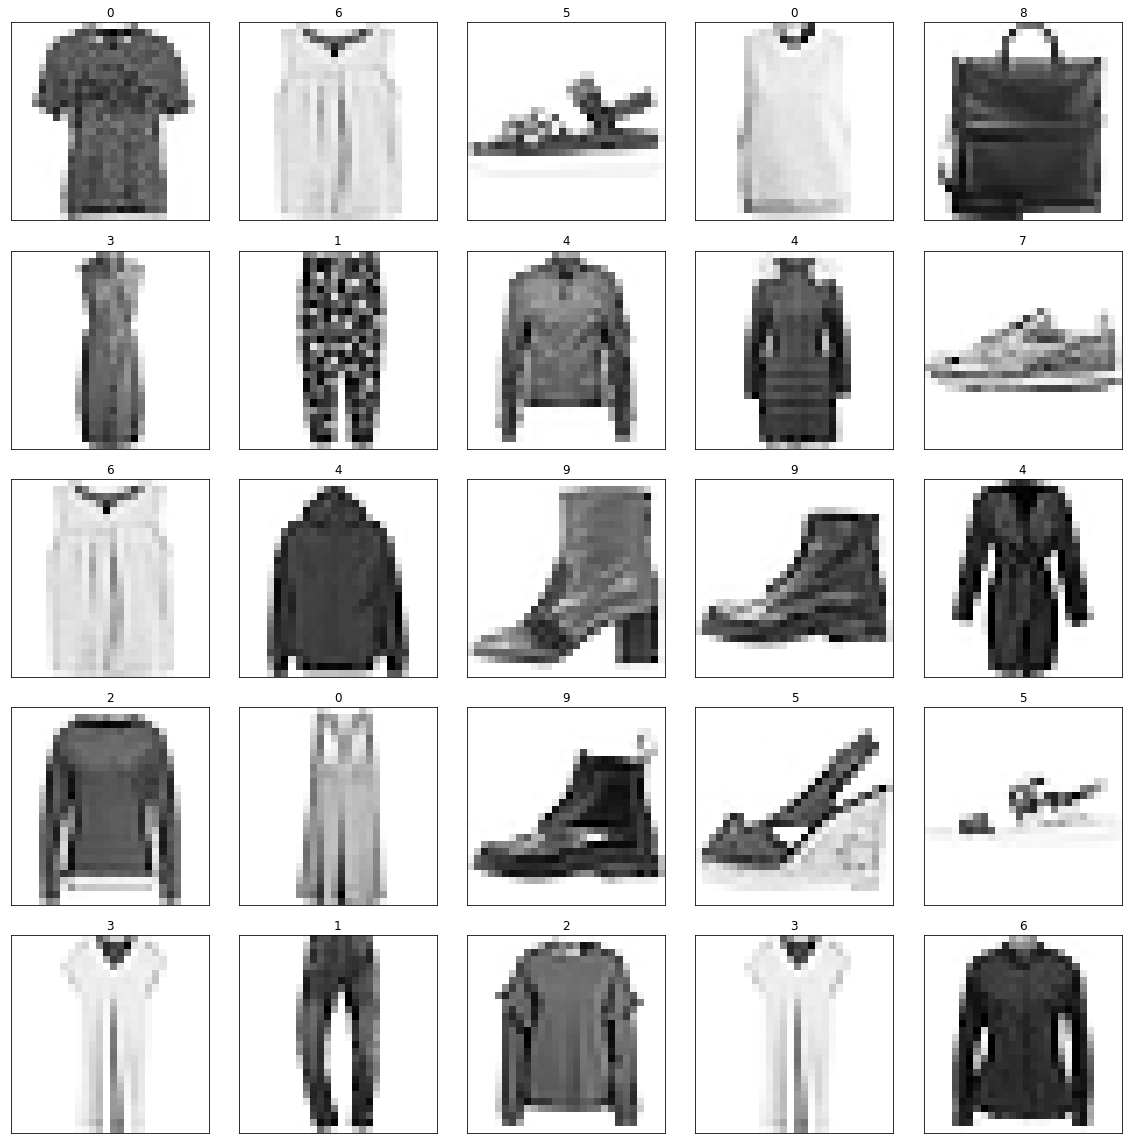

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_mnist(X, y, field_size=10):
    FIELD_SIZE = field_size

    ind = np.random.randint(0, X.shape[0], FIELD_SIZE*FIELD_SIZE)
    X_vis = X[ind, :].reshape(FIELD_SIZE, FIELD_SIZE, 28, 28) 
    y_vis = y[ind].reshape(FIELD_SIZE, FIELD_SIZE)

    plt.figure(figsize=(16, 16))

    for i in range(FIELD_SIZE):
        for j in range(FIELD_SIZE):
            plt.subplot(FIELD_SIZE, FIELD_SIZE, i*FIELD_SIZE+j+1)
            plt.imshow(X_vis[i, j, :], cmap=plt.cm.Greys)
            plt.gca().xaxis.set_ticks([])
            plt.gca().yaxis.set_ticks([])
            plt.title(y_vis[i, j])
    plt.tight_layout()
    plt.show()
    
visualize_mnist(X_sample,y_sample,field_size=5)
plt.show()

## Task 2.2

### Visualize data and produce embeddings

In [4]:
from FMNISTDataset import FMNISTDataset
fmnist = FMNISTDataset(random_state = 42,
                       use_augs = False)

In [5]:
X = fmnist.X
y = fmnist.y
X.shape,y.shape

((60000, 784), (60000,))

If you want to try UMAP, just
```
conda install -c conda-forge umap-learn
```
If you want to try datashader, just 
```
conda install datashader
```

In [6]:
# https://github.com/lmcinnes/umap
import umap   
from sklearn.decomposition import PCA

def project_features(n_components,
                     method):
    if method == 'pca':
        pca = PCA(n_components=n_components)
        pca.fit(X)
        print('PCA explained ratio {}'.format(sum(pca.explained_variance_ratio_))) 
        X_transformed = pca.transform(X)
        return X_transformed,pca
    elif method == 'umap':
        umap_ = umap.UMAP(
            n_neighbors=5,
            n_components=n_components,
            min_dist=0.1,
            metric='euclidean',
            init='random'
        )
        X_transformed = umap_.fit_transform(X)
        return X_transformed,umap_

In [7]:
import time
start_time = time.time()

X_transformed_pca_2,pca = project_features(2,'pca')
print('Time to run 2 PCA: {}'.format( time.time() - start_time))

X_transformed_pca_10,pca = project_features(10,'pca')
print('Time to run 10 PCA: {}'.format( time.time() - start_time))

PCA explained ratio 0.4679453789952793
Time to run 2 PCA: 2.67220401763916
PCA explained ratio 0.7199082694865548
Time to run 10 PCA: 5.068034410476685


In [8]:
X_transformed_umap_2,umap_ = project_features(2,'umap')
print('Time to run 2 UMAP: {}'.format( time.time() - start_time))
X_transformed_umap_10,umap_ = project_features(10,'umap')
print('Time to run 10 UMAP: {}'.format( time.time() - start_time))

Time to run 2 UMAP: 70.59682059288025
Time to run 10 UMAP: 142.4183316230774


In [9]:
X_transformed_pca_2.shape,X_transformed_pca_10.shape

((60000, 2), (60000, 10))

In [10]:
import pandas as pd

df_pca = pd.DataFrame()
df_pca['pca1'] = X_transformed_pca_2[:,0]
df_pca['pca2'] = X_transformed_pca_2[:,1]
df_pca['cat']  = y
df_pca['cat']  = df_pca['cat'].astype("category")

In [11]:
df_umap = pd.DataFrame()
df_umap['umap1'] = X_transformed_umap_2[:,0]
df_umap['umap2'] = X_transformed_umap_2[:,1]
df_umap['cat']  = y
df_umap['cat']  = df_umap['cat'].astype("category")

PCA,UMAP

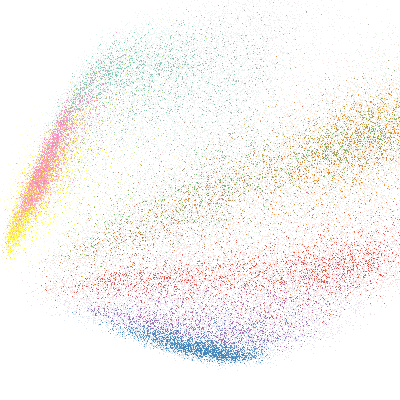
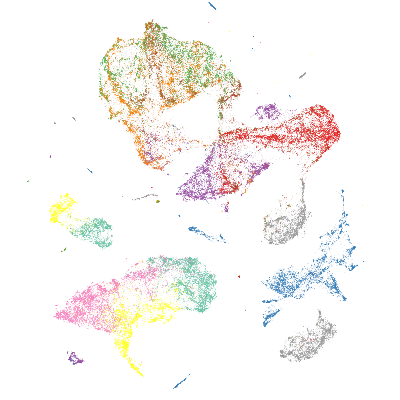

In [12]:
# following this tutorial 
# http://datashader.org/getting_started/2_Pipeline.html
import datashader as ds
import datashader.transfer_functions as tf

canvas = ds.Canvas(plot_width=400, plot_height=400, 
                   x_range=(-2000,2000), y_range=(-2000,2000), 
                   x_axis_type='linear', y_axis_type='linear')
aggc = canvas.points(df_pca, 'pca1', 'pca2', ds.count_cat('cat'))

canvas = ds.Canvas(plot_width=400, plot_height=400, 
                   x_range=(-11,11), y_range=(-11,11), 
                   x_axis_type='linear', y_axis_type='linear')
aggc_umap = canvas.points(df_umap, 'umap1', 'umap2', ds.count_cat('cat'))

tf.Images(tf.shade(aggc, name="PCA"),
          tf.shade(aggc_umap, name="UMAP"))


### Bench KNN

In [19]:
import numpy as np
import random 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

def stratified_sample(X,
                      y,
                      images_per_class):

    all_targets = list(y)
    samples = []
    targets = []

    for target_value in set(all_targets):
        indices = [i for i, e in enumerate(all_targets) if e == target_value]
        random.shuffle(indices)
        # produce max images_per_class
        indices = indices[:images_per_class]
        samples.append(X[np.asarray(indices)])
        targets.append(y[np.asarray(indices)])

    return np.vstack(samples),np.vstack(targets).reshape(-1)

def bench_knn(X,y,
              samples_per_class = [50, 100, 500, 1000, 3000],
              n_neighbours = [1,5,10,25,50]):
    
    stat_df = pd.DataFrame(columns=['samples_per_class','n_neighbours','accuracy'])

    for samples in samples_per_class:
        for neighbours in n_neighbours:

            X_,y_ =  stratified_sample(X,y,samples)

            skf = StratifiedKFold(n_splits = 5,
                                  shuffle = True,
                                  random_state = 42)

            f1, f2, f3, f4, f5 = skf.split(X_,y_)
            folds = [f1, f2, f3, f4, f5]

            accuracies = []

            for fold in folds:
                train_idx = fold[0]
                val_idx = fold[1] 

                knn_params = {'n_neighbors':neighbours,
                     'weights':'distance',
                     'n_jobs':6}

                knn = KNeighborsClassifier(**knn_params)
                knn.fit(X_[train_idx], y_[train_idx]) 
                accuracy = knn.score(X_[val_idx],y_[val_idx])
                accuracies.append(accuracy)

            # this is NOT a proper way to measure this!
            # ideally you should go for some variation of ROC AUC score
            mean_accuracy = sum(accuracies)/len(accuracies)
            stat_df = stat_df.append(pd.DataFrame(columns=['samples_per_class','n_neighbours','accuracy'],data=[[samples,neighbours,mean_accuracy]]))
        
    return stat_df

In [ ]:
!pip install seaborn

In [16]:
import seaborn as sns

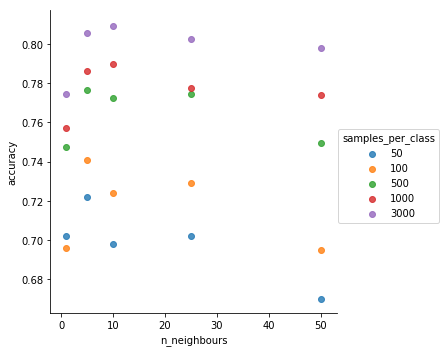

In [20]:
# try benching with 10 dimensional data with PCA
stat_df = bench_knn(X_transformed_pca_10,y)
g = sns.lmplot(x="n_neighbours", y="accuracy", hue="samples_per_class", data=stat_df, fit_reg=False)

In [21]:
stat_df[stat_df.samples_per_class==500]

,samples_per_class,n_neighbours,accuracy
0,500,1,0.7476
0,500,5,0.7766
0,500,10,0.7724
0,500,25,0.7746
0,500,50,0.7494


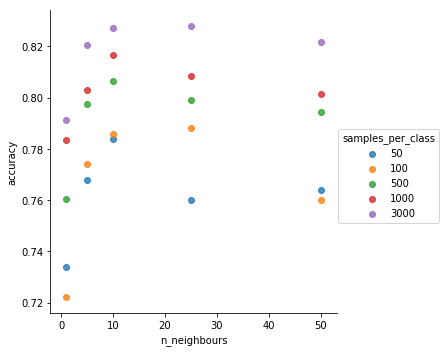

In [22]:
# try benching with 10 dimensional data with UMAP
stat_df = bench_knn(X_transformed_umap_10,y)
g = sns.lmplot(x="n_neighbours", y="accuracy", hue="samples_per_class", data=stat_df, fit_reg=False)

In [24]:
stat_df[stat_df.samples_per_class==500]

,samples_per_class,n_neighbours,accuracy
0,500,1,0.7604
0,500,5,0.7974
0,500,10,0.8064
0,500,25,0.7990
0,500,50,0.7946


In [26]:
# Report the accuracy on the test set (the one remained untouched)
knn_params = {'n_neighbors':5,
     'weights':'uniform',
     'n_jobs':6}

X_,y_ =  stratified_sample(X_transformed_pca_10,y,500)
X_test, y_test = fmnist.X_test, fmnist.y_test
X_test_transformed = pca.transform(X_test)

knn = KNeighborsClassifier(**knn_params)
knn.fit(X_, y_) 
accuracy = knn.score(X_test_transformed,y_test)
print(accuracy)

0.7693


UMAP API does not contain the same transform function, that can be applied after fit.
https://github.com/lmcinnes/umap/issues/55

## Task 2.3

In [27]:
from FMNISTDataset import FMNISTDataset
fmnist = FMNISTDataset(random_state = 42,
                       use_augs = False)
X = fmnist.X
y = fmnist.y
X.shape,y.shape

((60000, 784), (60000,))

In [28]:
!ls laht weights/fmnist_fc_conv_l10_rebalance_no_norm_*

ls: cannot access 'laht': No such file or directory
weights/fmnist_fc_conv_l10_rebalance_no_norm_best.pth.tar
weights/fmnist_fc_conv_l10_rebalance_no_norm_checkpoint.pth.tar


In [29]:
import torch
import torch.nn as nn
import torch.utils.data
from torch.nn import Sigmoid
from VAE import VAEBaselineConv
from FMNISTDataset import FMNISTDataset

cuda = True
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

model = VAEBaselineConv(latent_space_size=10).to(device)

resume = 'weights/fmnist_fc_conv_l10_rebalance_no_norm_best.pth.tar'
print("=> loading checkpoint '{}'".format(resume))
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))


eval_train_dataset = FMNISTDataset(mode = 'eval_train',
                                   random_state = 42,
                                   use_augs = False)

eval_test_dataset = FMNISTDataset(mode = 'eval_test',
                                   random_state = 42,
                                   use_augs = False)

eval_train_loader = torch.utils.data.DataLoader(
    eval_train_dataset,
    batch_size=512,        
    shuffle=False,
    drop_last=False,
    **kwargs)            

eval_test_loader = torch.utils.data.DataLoader(
    eval_test_dataset,
    batch_size=512,        
    shuffle=False,
    drop_last=False,
    **kwargs)    

Total model parameters 119591
=> loading checkpoint 'weights/fmnist_fc_conv_l10_rebalance_no_norm_best.pth.tar'
=> loaded checkpoint (epoch 30)


In [30]:
import tqdm

train_vae_embeddings = []
train_y_values = []
test_vae_embeddings = []

# collect embeddings for the train dataset
with tqdm.tqdm(total=len(eval_train_loader)) as pbar:
    with torch.no_grad():
        for i, (input, target) in enumerate(eval_train_loader):
            input = input.float().to(device)
            out, mu, logvar = model(input)
            
            train_vae_embeddings.append(mu.cpu().numpy().reshape(-1,10))
            train_y_values.append(target.cpu().numpy())
            pbar.update(1)

100%|██████████| 118/118 [00:04<00:00, 25.93it/s]


In [31]:
# collect embeddings for the train dataset
with tqdm.tqdm(total=len(eval_test_loader)) as pbar:
    with torch.no_grad():
        for i, (input, target) in enumerate(eval_test_loader):
            input = input.float().to(device)
            out, mu, logvar = model(input)
            test_vae_embeddings.append(mu.cpu().numpy().reshape(-1,10))
            pbar.update(1)

100%|██████████| 20/20 [00:00<00:00, 26.08it/s]


In [32]:
import numpy as np

train_y_values = np.concatenate(train_y_values)
train_y_values.shape

(60000,)

In [33]:
# check that generators worked correctly 
assert (train_y_values==y).all()

In [34]:
train_vae_embeddings = np.concatenate(train_vae_embeddings)
test_vae_embeddings = np.concatenate(test_vae_embeddings)

In [35]:
train_vae_embeddings.shape,test_vae_embeddings.shape

((60000, 10), (10000, 10))

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_vae_embeddings)
print('PCA explained ratio {}'.format(sum(pca.explained_variance_ratio_))) 
train_vae_embeddings_pca_2 = pca.transform(train_vae_embeddings)

PCA explained ratio 0.41148026287555695


In [37]:
import pandas as pd

df_pca = pd.DataFrame()
df_pca['pca1'] = train_vae_embeddings_pca_2[:,0]
df_pca['pca2'] = train_vae_embeddings_pca_2[:,1]
df_pca['cat']  = y
df_pca['cat']  = df_pca['cat'].astype("category")

VAE

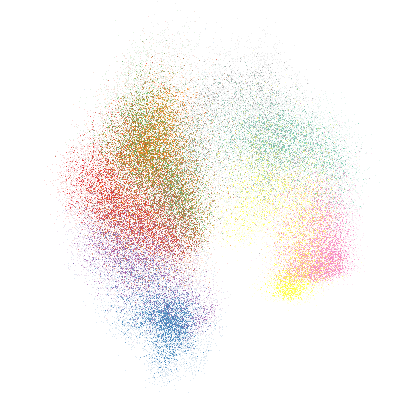

In [38]:
# following this tutorial 
# http://datashader.org/getting_started/2_Pipeline.html
import datashader as ds
import datashader.transfer_functions as tf

canvas = ds.Canvas(plot_width=400, plot_height=400, 
                   x_range=(-4,4), y_range=(-4,4), 
                   x_axis_type='linear', y_axis_type='linear')
aggc = canvas.points(df_pca, 'pca1', 'pca2', ds.count_cat('cat'))

tf.Images(tf.shade(aggc, name="VAE"))

Let's compare the embeddings
![](compare.png)

In [39]:
stat_df = bench_knn(train_vae_embeddings,y)

In [40]:
stat_df[stat_df.samples_per_class==500]

,samples_per_class,n_neighbours,accuracy
0,500,1,0.7890
0,500,5,0.8028
0,500,10,0.8076
0,500,25,0.8062
0,500,50,0.7966


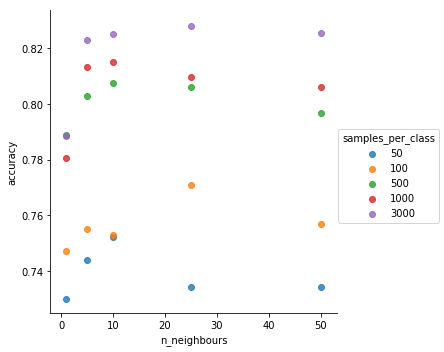

In [41]:
import seaborn as sns
g = sns.lmplot(x="n_neighbours", y="accuracy", hue="samples_per_class", data=stat_df, fit_reg=False)

In [52]:
# Report the accuracy on the test set (the one remained untouched)
knn_params = {'n_neighbors':10,
     'weights':'uniform',
     'n_jobs':6}

X_,y_ =  stratified_sample(train_vae_embeddings,y,500)
X_test, y_test = fmnist.X_test, fmnist.y_test

knn = KNeighborsClassifier(**knn_params)
knn.fit(X_, y_) 
accuracy = knn.score(test_vae_embeddings,y_test)
print(accuracy)

0.8016


# Conclusions


It seems that VAE was better both on train/val as well as on the test dataset.


Notably on train/val dataset its accuracy was similar to UMAP - also a non-linear method.
I belive that the reason for that is non-linearity of CNNs and UMAP - they can learn more complex dependencies.



Also it is interesting to note that:
- VAEs seem to have fullfilled their task - the learned embedding seems to have no huge holes - there is a continuous path between the majority of the classes and they seem separable (compare to UMAP visually - there is a lot of blank space there)
- As for the blank space, I have not tested it, but it is interesting what may lay there =)

I see several different ways of improvement:
1. **Computational** - play with:
    - Ensembling / folding / blending. Although this method is superficial, it mostly always works with CNNS;
    - Increase network's capacity, e.g. lift 120k param limit;
    - Try combining different methods (PCA, CNNs, UMAP - think about a meta-architecture to combine these three);
    
    
2. **Architecture** - I did not explicitly look for new VAE papers, as they seem to be more focused on math, instead of concrete architectures and know-hows (and the domain - fmnist - seems to be really "simple") - but improving a CNN architecture is definetely a way, even though all my naive experiments failed more or less;


3. **Conditioning** - I read some papers on cGANs and CycleGANs. The idea is, that if in this case we have some a priori information about the class of the object (i.e. a shoe) this information will be somehow encoded into the CNN, when traning. If we pass this information somehow to the CNN (e.g. learn a separate distribution for each class / separate network for each class) - then the CNN's capacity will be used to refine the encoding, instead of classifying the objects;

!!!

**Caveat** - I have not really seen people effectively using VAEs on Imagenet scale tasks or any difficult domains

!!!